<a href="https://colab.research.google.com/github/danielee3/ProjectWX/blob/main/WILL_IT_RAIN_IN_ITHACA%3F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [ ]:
ithaca = pd.read_csv('/content/drive/MyDrive/Weather ML Project/RAW DATA/ITH.csv')

# station: three or four character site identifier (ITH 일 경우 이타카 공항)
# valid: timestamp of the observation (관측이 행해진 날짜와 시간)
# tmpf: Air Temperature in Fahrenheit, typically @ 2 meters (화씨 기온)
# dwpf: Dew Point Temperature in Fahrenheit, typically @ 2 meters (화씨 노점 온도 - 높을수록 습도가 높음)
# relh: Relative Humidity in % (상대 습도)
# drct: Wind Direction in degrees from north (풍향)
# sknt: Wind Speed in knots (풍속)
# p01i: One hour precipitation for the period from the observation time to the time of the previous hourly precipitation reset. (1시간 강수량)
# alti: Pressure altimeter in inches (기압)
# mslp: Sea Level Pressure in millibar (해면기압 - 위의 기압과 linear한 상관관계가 있음)
# vsby: Visibility in miles (시정 - 안개나 미세먼지 등으로 인해 시야가 얼마나 흐려졌는지에 대한 값)
# gust: Wind Gust in knots (순간 최대 풍속 - 갑자기 강하게 분 바람)
# skyc1: Sky Level 1 Coverage (가장 낮은 층 구름의 양: SKC - FEW - SCT - BKN - OVC 순으로 구름이 많아짐을 뜻함)
# skyc2: Sky Level 2 Coverage (두 번째로 낮은 층 구름의 양)
# skyc3: Sky Level 3 Coverage (세 번째로 낮은 층 구름의 양)
# skyc4: Sky Level 4 Coverage (네 번째로 낮은 층 구름의 양)
# skyl1: Sky Level 1 Altitude in feet (가장 낮은 층 구름의 높이)
# skyl2: Sky Level 2 Altitude in feet (두 번째로 낮은 층 구름의 높이)
# skyl3: Sky Level 3 Altitude in feet (세 번재로 낮은 층 구름의 높이)
# skyl4: Sky Level 4 Altitude in feet (네 번째로 낮은 층 구름의 높이)
# wxcodes: Present Weather Codes (space seperated) (현재 날씨 상황 - 예를 들어 RA일 경우 비가 오고 있음).

ithaca.drop(['ice_accretion_1hr', 'ice_accretion_3hr', 'ice_accretion_6hr', 'peak_wind_gust', 'peak_wind_drct', 'peak_wind_time', 'feel', 'metar'], axis='columns', inplace=True)
print(ithaca.shape)
ithaca.tail()

(21481, 21)


,station,valid,tmpf,dwpf,relh,drct,sknt,p01i,alti,mslp,vsby,gust,skyc1,skyc2,skyc3,skyc4,skyl1,skyl2,skyl3,skyl4,wxcodes
21476,ITH,2020-05-30 19:56,66.90,54.00,63.21,320.00,15.00,0.00,29.91,1012.50,10.00,20.00,SCT,SCT,M,M,5500.00,7000.00,M,M,M
21477,ITH,2020-05-30 20:56,66.00,50.00,56.27,280.00,12.00,0.00,29.92,1013.00,10.00,21.00,BKN,BKN,M,M,5500.00,8000.00,M,M,M
21478,ITH,2020-05-30 21:56,64.00,52.00,64.97,330.00,14.00,0.00,29.94,1013.70,10.00,20.00,BKN,OVC,M,M,4800.00,6000.00,M,M,M
21479,ITH,2020-05-30 22:56,62.10,48.90,61.91,300.00,16.00,0.00,29.96,1014.40,10.00,20.00,SCT,BKN,M,M,5000.00,7500.00,M,M,M
21480,ITH,2020-05-30 23:56,60.10,48.00,64.26,300.00,11.00,0.00,30.00,1015.70,10.00,M,FEW,SCT,M,M,4500.00,7500.00,M,M,M


In [ ]:
ithaca.dtypes

station    object
valid      object
tmpf       object
dwpf       object
relh       object
drct       object
sknt       object
p01i       object
alti       object
mslp       object
vsby       object
gust       object
skyc1      object
skyc2      object
skyc3      object
skyc4      object
skyl1      object
skyl2      object
skyl3      object
skyl4      object
wxcodes    object
dtype: object

In [ ]:
ithaca['valid'] = pd.to_datetime(ithaca['valid'], format='%Y-%m-%d %H:%M')

In [ ]:
ithaca_M = ithaca[(ithaca['tmpf']=='M') | (ithaca['dwpf']=='M') | (ithaca['relh']=='M') | (ithaca['drct']=='M') | (ithaca['vsby']=='M') | (ithaca['sknt']=='M') | (ithaca['mslp']=='M')].index #indices with 'M'
octas_dict = {'CLR':0.00, 'FEW':0.25, 'SCT':0.50, 'BKN':0.75, 'OVC':1.00, 'M':0.00, 'VV ':1.00}
height_dict = {'M':0.00}
ithaca = ithaca.replace({'skyc1': octas_dict})
ithaca = ithaca.replace({'skyc2': octas_dict})
ithaca = ithaca.replace({'skyc3': octas_dict})
ithaca = ithaca.replace({'skyc4': octas_dict})
ithaca = ithaca.replace({'skyl1': height_dict})
ithaca = ithaca.replace({'skyl2': height_dict})
ithaca = ithaca.replace({'skyl3': height_dict})
ithaca = ithaca.replace({'skyl4': height_dict})
ithaca = ithaca.drop(ithaca_M)

mutated_cols = ['tmpf','dwpf','relh','drct','sknt','vsby','skyc1','skyc2','skyc3','skyc4','skyl1','skyl2','skyl3','skyl4','mslp']

ithaca[mutated_cols] = ithaca[mutated_cols].apply(pd.to_numeric)
#ithaca['dwpf'] = pd.to_numeric(ithaca['dwpf'])
ithaca.dtypes


station            object
valid      datetime64[ns]
tmpf              float64
dwpf              float64
relh              float64
drct              float64
sknt              float64
p01i               object
alti               object
mslp              float64
vsby              float64
gust               object
skyc1             float64
skyc2             float64
skyc3             float64
skyc4             float64
skyl1             float64
skyl2             float64
skyl3             float64
skyl4             float64
wxcodes            object
dtype: object

In [ ]:
ithaca.shape #mslp has a lot of missing data!

(16551, 21)

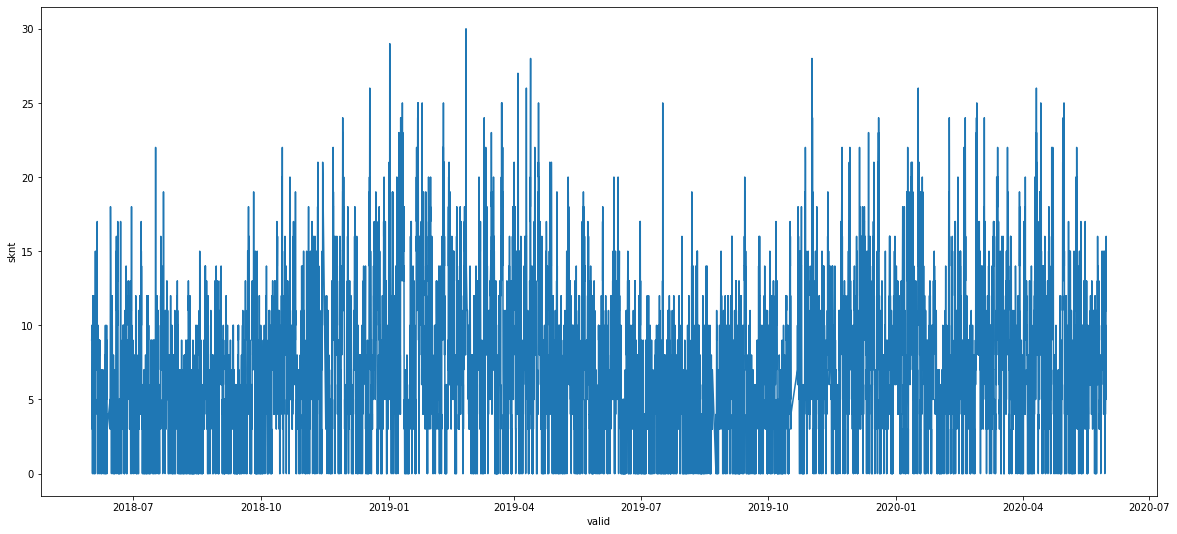

In [ ]:
plt.figure(figsize=(20, 9))
sns.lineplot(y=ithaca['sknt'], x=ithaca['valid'])

In [ ]:
ithaca['rain'] = ithaca['wxcodes'].str.contains("RA|DZ|TS|SN|GR")
ithaca.head(30)

,station,valid,tmpf,dwpf,relh,drct,sknt,p01i,alti,mslp,vsby,gust,skyc1,skyc2,skyc3,skyc4,skyl1,skyl2,skyl3,skyl4,wxcodes,rain
1,ITH,2018-06-01 00:56:00,72.0,66.0,81.41,190.0,9.0,0.00,29.88,1011.3,10.00,M,1.00,0.00,0.0,0.0,1900.0,0.0,0.0,0.0,M,False
2,ITH,2018-06-01 01:56:00,71.1,66.0,83.93,170.0,9.0,T,29.87,1010.7,10.00,M,1.00,0.00,0.0,0.0,1900.0,0.0,0.0,0.0,M,False
3,ITH,2018-06-01 02:56:00,70.0,66.9,89.90,170.0,10.0,0.00,29.85,1010.1,10.00,M,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,M,False
6,ITH,2018-06-01 03:56:00,71.1,66.9,86.59,190.0,6.0,0.00,29.86,1010.5,10.00,M,0.75,0.75,0.0,0.0,1600.0,2100.0,0.0,0.0,M,False
8,ITH,2018-06-01 04:56:00,70.0,66.0,87.14,170.0,7.0,0.00,29.84,1009.9,10.00,M,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,M,False
11,ITH,2018-06-01 06:56:00,69.1,66.0,89.86,140.0,5.0,0.00,29.83,1009.4,10.00,M,1.00,0.00,0.0,0.0,1600.0,0.0,0.0,0.0,M,False
13,ITH,2018-06-01 07:56:00,70.0,66.9,89.90,160.0,4.0,0.00,29.83,1009.3,10.00,M,1.00,0.00,0.0,0.0,1400.0,0.0,0.0,0.0,M,False
15,ITH,2018-06-01 08:56:00,69.1,66.0,89.86,160.0,5.0,0.00,29.82,1009.1,10.00,M,0.50,0.00,0.0,0.0,1600.0,0.0,0.0,0.0,M,False
16,ITH,2018-06-01 09:56:00,66.9,66.0,96.93,120.0,3.0,0.00,29.82,1009.2,10.00,M,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,M,False
17,ITH,2018-06-01 10:56:00,71.1,66.9,86.59,160.0,6.0,0.00,29.82,1009.2,10.00,M,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,M,False


In [ ]:
ithaca = pd.get_dummies(ithaca, columns = ['rain'])

In [ ]:
ithaca.head(30)

,station,valid,tmpf,dwpf,relh,drct,sknt,p01i,alti,mslp,vsby,gust,skyc1,skyc2,skyc3,skyc4,skyl1,skyl2,skyl3,skyl4,wxcodes,rain_False,rain_True
1,ITH,2018-06-01 00:56:00,72.0,66.0,81.41,190.0,9.0,0.00,29.88,1011.3,10.00,M,1.00,0.00,0.0,0.0,1900.0,0.0,0.0,0.0,M,1,0
2,ITH,2018-06-01 01:56:00,71.1,66.0,83.93,170.0,9.0,T,29.87,1010.7,10.00,M,1.00,0.00,0.0,0.0,1900.0,0.0,0.0,0.0,M,1,0
3,ITH,2018-06-01 02:56:00,70.0,66.9,89.90,170.0,10.0,0.00,29.85,1010.1,10.00,M,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,M,1,0
6,ITH,2018-06-01 03:56:00,71.1,66.9,86.59,190.0,6.0,0.00,29.86,1010.5,10.00,M,0.75,0.75,0.0,0.0,1600.0,2100.0,0.0,0.0,M,1,0
8,ITH,2018-06-01 04:56:00,70.0,66.0,87.14,170.0,7.0,0.00,29.84,1009.9,10.00,M,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,M,1,0
11,ITH,2018-06-01 06:56:00,69.1,66.0,89.86,140.0,5.0,0.00,29.83,1009.4,10.00,M,1.00,0.00,0.0,0.0,1600.0,0.0,0.0,0.0,M,1,0
13,ITH,2018-06-01 07:56:00,70.0,66.9,89.90,160.0,4.0,0.00,29.83,1009.3,10.00,M,1.00,0.00,0.0,0.0,1400.0,0.0,0.0,0.0,M,1,0
15,ITH,2018-06-01 08:56:00,69.1,66.0,89.86,160.0,5.0,0.00,29.82,1009.1,10.00,M,0.50,0.00,0.0,0.0,1600.0,0.0,0.0,0.0,M,1,0
16,ITH,2018-06-01 09:56:00,66.9,66.0,96.93,120.0,3.0,0.00,29.82,1009.2,10.00,M,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,M,1,0
17,ITH,2018-06-01 10:56:00,71.1,66.9,86.59,160.0,6.0,0.00,29.82,1009.2,10.00,M,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,M,1,0


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

#select columns to be scaled
scale_cols = mutated_cols + ['rain_True', 'rain_False']
#fit and transform(return a new array) the array
scaled = scaler.fit_transform(ithaca[scale_cols])

#make scaled into a pandas data frame
ith_scaled = pd.DataFrame(scaled)
#give column names
ith_scaled.columns = scale_cols
ith_scaled


,tmpf,dwpf,relh,drct,sknt,vsby,skyc1,skyc2,skyc3,skyc4,skyl1,skyl2,skyl3,skyl4,mslp,rain_True,rain_False
0,0.793006,0.876656,0.781705,0.527778,0.300000,1.0,1.00,0.00,0.0,0.0,0.158333,0.000000,0.0,0.0,0.447458,0.0,1.0
1,0.784499,0.876656,0.811296,0.472222,0.300000,1.0,1.00,0.00,0.0,0.0,0.158333,0.000000,0.0,0.0,0.437288,0.0,1.0
2,0.774102,0.885831,0.881400,0.472222,0.333333,1.0,0.00,0.00,0.0,0.0,0.000000,0.000000,0.0,0.0,0.427119,0.0,1.0
3,0.784499,0.885831,0.842532,0.527778,0.200000,1.0,0.75,0.75,0.0,0.0,0.133333,0.175000,0.0,0.0,0.433898,0.0,1.0
4,0.774102,0.876656,0.848990,0.472222,0.233333,1.0,0.00,0.00,0.0,0.0,0.000000,0.000000,0.0,0.0,0.423729,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16546,0.744802,0.754332,0.567990,0.888889,0.500000,1.0,0.50,0.50,0.0,0.0,0.458333,0.583333,0.0,0.0,0.467797,0.0,1.0
16547,0.736295,0.713558,0.486496,0.777778,0.400000,1.0,0.75,0.75,0.0,0.0,0.458333,0.666667,0.0,0.0,0.476271,0.0,1.0
16548,0.717391,0.733945,0.588657,0.916667,0.466667,1.0,0.75,1.00,0.0,0.0,0.400000,0.500000,0.0,0.0,0.488136,0.0,1.0
16549,0.699433,0.702345,0.552724,0.833333,0.533333,1.0,0.50,0.75,0.0,0.0,0.416667,0.625000,0.0,0.0,0.500000,0.0,1.0


In [ ]:
x = ith_scaled[mutated_cols]
y = ith_scaled[['rain_False', 'rain_True']]
print(x.shape, y.shape)

(16551, 15) (16551, 2)


In [ ]:
X = tf.keras.layers.Input(shape=[15]) #number of feature columns
#activation function

#hidden layers
H = tf.keras.layers.Dense(15)(X)
H = tf.keras.layers.BatchNormalization()(H)
H = tf.keras.layers.Activation('swish')(H)
H = tf.keras.layers.Dense(15)(H)
H = tf.keras.layers.BatchNormalization()(H)
H = tf.keras.layers.Activation('swish')(H)
H = tf.keras.layers.Dense(15)(H)
H = tf.keras.layers.BatchNormalization()(H)
H = tf.keras.layers.Activation('swish')(H)


Y = tf.keras.layers.Dense(2, activation='sigmoid')(H) #3 because there are 3 categories
#softmax: makes everything between 0 and 1 (sigmoid is for binary classification)
model = tf.keras.models.Model(X,Y)
#loss... metrics... 
model.compile(loss='categorical_crossentropy', metrics='accuracy')

In [ ]:
model.fit(x, y, epochs=30)

Epoch 1/30
518/518 [==============================] - 1s 1ms/step - loss: 0.3256 - accuracy: 0.8607
Epoch 2/30
518/518 [==============================] - 1s 2ms/step - loss: 0.2665 - accuracy: 0.8838
Epoch 3/30
518/518 [==============================] - 1s 1ms/step - loss: 0.2535 - accuracy: 0.8896
Epoch 4/30
518/518 [==============================] - 1s 2ms/step - loss: 0.2503 - accuracy: 0.8936
Epoch 5/30
518/518 [==============================] - 1s 1ms/step - loss: 0.2439 - accuracy: 0.8976
Epoch 6/30
518/518 [==============================] - 1s 1ms/step - loss: 0.2447 - accuracy: 0.8961
Epoch 7/30
518/518 [==============================] - 1s 1ms/step - loss: 0.2393 - accuracy: 0.8989
Epoch 8/30
518/518 [==============================] - 1s 1ms/step - loss: 0.2393 - accuracy: 0.9027
Epoch 9/30
518/518 [==============================] - 1s 1ms/step - loss: 0.2380 - accuracy: 0.8998
Epoch 10/30
518/518 [==============================] - 1s 2ms/step - loss: 0.2360 - accuracy: 0.9027

In [ ]:
model.fit(x, y, epochs=15)

Epoch 1/15
518/518 [==============================] - 1s 1ms/step - loss: 0.2256 - accuracy: 0.9073
Epoch 2/15
518/518 [==============================] - 1s 1ms/step - loss: 0.2250 - accuracy: 0.9071
Epoch 3/15
518/518 [==============================] - 1s 2ms/step - loss: 0.2256 - accuracy: 0.9054
Epoch 4/15
518/518 [==============================] - 1s 2ms/step - loss: 0.2250 - accuracy: 0.9074
Epoch 5/15
518/518 [==============================] - 1s 1ms/step - loss: 0.2264 - accuracy: 0.9074
Epoch 6/15
518/518 [==============================] - 1s 1ms/step - loss: 0.2235 - accuracy: 0.9073
Epoch 7/15
518/518 [==============================] - 1s 2ms/step - loss: 0.2238 - accuracy: 0.9071
Epoch 8/15
518/518 [==============================] - 1s 2ms/step - loss: 0.2234 - accuracy: 0.9064
Epoch 9/15
518/518 [==============================] - 1s 2ms/step - loss: 0.2246 - accuracy: 0.9083
Epoch 10/15
518/518 [==============================] - 1s 2ms/step - loss: 0.2236 - accuracy: 0.9076

In [ ]:
print(model.predict(x[20:40]))

[[0.9520031  0.0031361 ]
 [0.83767104 0.06485456]
 [0.7932204  0.05904675]
 [0.6923006  0.1417101 ]
 [0.4366162  0.25495526]
 [0.6487334  0.4737631 ]
 [0.42568016 0.41006204]
 [0.4089493  0.64158213]
 [0.7467253  0.15513062]
 [0.81326485 0.35148606]
 [0.8384626  0.12570578]
 [0.9286717  0.01748356]
 [0.95543694 0.01959169]
 [0.9602858  0.0949536 ]
 [0.9893675  0.01325589]
 [0.99525523 0.00981542]
 [0.99450374 0.0106875 ]
 [0.99616075 0.0085572 ]
 [0.9726341  0.06485593]
 [0.9407984  0.14232671]]


In [ ]:
print(model.predict(x[20:40]))

[[9.3541670e-01 3.1614155e-02]
 [7.5462759e-01 7.3256791e-03]
 [3.4155932e-01 1.1370778e-03]
 [1.2297100e-01 2.3680563e-05]
 [5.5420589e-01 1.6448030e-01]
 [9.2773426e-01 5.4185420e-02]
 [8.4023362e-01 4.5842648e-02]
 [6.6725361e-01 3.7238199e-01]
 [5.8663839e-01 4.1992787e-01]
 [5.7443941e-01 4.6740553e-01]
 [3.7145719e-01 6.9253504e-01]
 [5.8073968e-01 5.6638443e-01]
 [4.6939957e-01 6.9583720e-01]
 [5.5846047e-01 5.9267497e-01]
 [4.9425220e-01 6.4231849e-01]
 [5.6049645e-01 4.6555153e-01]
 [7.8811550e-01 7.9945564e-02]
 [8.1581163e-01 4.8488796e-02]
 [8.4501767e-01 1.8760026e-02]
 [8.9920574e-01 1.1571854e-02]]


In [ ]:
print(y[20:40])

    rain_False  rain_True
20         1.0        0.0
21         1.0        0.0
22         0.0        1.0
23         0.0        1.0
24         0.0        1.0
25         0.0        1.0
26         0.0        1.0
27         0.0        1.0
28         0.0        1.0
29         0.0        1.0
30         0.0        1.0
31         1.0        0.0
32         1.0        0.0
33         1.0        0.0
34         1.0        0.0
35         1.0        0.0
36         1.0        0.0
37         1.0        0.0
38         1.0        0.0
39         1.0        0.0


In [ ]:
ithaca[ithaca['rain_True'] == 1]

,station,valid,tmpf,dwpf,relh,drct,sknt,p01i,alti,mslp,vsby,gust,skyc1,skyc2,skyc3,skyc4,skyl1,skyl2,skyl3,skyl4,wxcodes,rain_False,rain_True
25,ITH,2018-06-01 18:56:00,84.9,69.1,59.21,250.0,8.0,0.00,29.77,1007.00,10.00,M,BKN,M,M,M,4400.00,M,M,M,VCTS,0,1
26,ITH,2018-06-01 19:56:00,72.0,66.0,81.41,310.0,12.0,0.00,29.80,1008.30,10.00,17.00,BKN,M,M,M,5500.00,M,M,M,TS,0,1
27,ITH,2018-06-01 20:08:00,69.8,66.2,88.34,270.0,11.0,T,29.81,M,10.00,M,SCT,BKN,M,M,2300.00,4700.00,M,M,-RA,0,1
28,ITH,2018-06-01 20:24:00,69.8,66.2,88.34,300.0,4.0,0.01,29.80,M,7.00,M,SCT,BKN,M,M,2100.00,5000.00,M,M,VCTS -RA,0,1
29,ITH,2018-06-01 20:40:00,69.8,66.2,88.34,60.0,5.0,0.02,29.80,M,7.00,M,FEW,BKN,M,M,2500.00,4500.00,M,M,-TSRA,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21449,ITH,2020-05-29 23:06:00,69.8,68.0,94.01,240.0,4.0,0.04,29.84,M,8.00,M,FEW,BKN,OVC,M,2500.00,4500.00,5500.00,M,VCTS +RA,0,1
21456,ITH,2020-05-30 04:40:00,64.4,59.0,82.62,260.0,9.0,T,29.89,M,10.00,M,BKN,OVC,M,M,2300.00,3100.00,M,M,-RA,0,1
21457,ITH,2020-05-30 04:56:00,62.1,59.0,89.57,290.0,13.0,T,29.90,1011.70,7.00,19.00,SCT,BKN,OVC,M,1800.00,2300.00,2800.00,M,-RA,0,1
21458,ITH,2020-05-30 05:04:00,60.8,59.0,93.79,300.0,19.0,0.01,29.91,M,5.00,M,SCT,SCT,OVC,M,900.00,1400.00,2100.00,M,-RA BR,0,1


In [ ]:
ithaca[ithaca['rain_False'] == 1]

,station,valid,tmpf,dwpf,relh,drct,sknt,p01i,alti,mslp,vsby,gust,skyc1,skyc2,skyc3,skyc4,skyl1,skyl2,skyl3,skyl4,wxcodes,rain_False,rain_True
0,ITH,2018-06-01 00:19:00,73.4,66.2,78.19,180.0,8.0,0.00,29.88,M,10.00,M,BKN,M,M,M,2600.00,M,M,M,M,1,0
1,ITH,2018-06-01 00:56:00,72.0,66.0,81.41,190.0,9.0,0.00,29.88,1011.30,10.00,M,OVC,M,M,M,1900.00,M,M,M,M,1,0
2,ITH,2018-06-01 01:56:00,71.1,66.0,83.93,170.0,9.0,T,29.87,1010.70,10.00,M,OVC,M,M,M,1900.00,M,M,M,M,1,0
3,ITH,2018-06-01 02:56:00,70.0,66.9,89.90,170.0,10.0,0.00,29.85,1010.10,10.00,M,CLR,M,M,M,M,M,M,M,M,1,0
4,ITH,2018-06-01 03:19:00,71.6,66.2,83.09,200.0,7.0,0.00,29.86,M,10.00,M,BKN,M,M,M,1600.00,M,M,M,M,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21476,ITH,2020-05-30 19:56:00,66.9,54.0,63.21,320.0,15.0,0.00,29.91,1012.50,10.00,20.00,SCT,SCT,M,M,5500.00,7000.00,M,M,M,1,0
21477,ITH,2020-05-30 20:56:00,66.0,50.0,56.27,280.0,12.0,0.00,29.92,1013.00,10.00,21.00,BKN,BKN,M,M,5500.00,8000.00,M,M,M,1,0
21478,ITH,2020-05-30 21:56:00,64.0,52.0,64.97,330.0,14.0,0.00,29.94,1013.70,10.00,20.00,BKN,OVC,M,M,4800.00,6000.00,M,M,M,1,0
21479,ITH,2020-05-30 22:56:00,62.1,48.9,61.91,300.0,16.0,0.00,29.96,1014.40,10.00,20.00,SCT,BKN,M,M,5000.00,7500.00,M,M,M,1,0
